
# Adding Limit Orders to the Trading Bot (Take Profit & Stop Loss) 

In [1]:
import sys
sys.path.append("../")
from trading.api import OANDA_API
import pandas as pd
import numpy as np
import tpqoa
from datetime import datetime, timedelta, timezone
import time
import pytz
from datetime import datetime

import matplotlib.pyplot as plt
from trading import MyTT

In [2]:
instrument = "EUR_USD"
bar_length = timedelta(minutes = 1)
SMA = 200
dev = 2

In [ ]:
# raw_data = None
# now = datetime.utcnow()
       
# now = now - timedelta(microseconds = now.microsecond)
# past = now - timedelta(days = 2)


# print (f"Getting candles for {instrument}, from {past} to {now}")

# raw_df = tpqoa.tpqoa("../../config/oanda_demo.cfg").get_history(instrument = instrument, start = past, end = now,
#                        granularity = "S30", price = "M", localize = True).c.dropna().to_frame()

# raw_df.rename(columns = {"c":instrument}, inplace = True)


# # last_bar = raw_data.index[-1].to_pydatetime().replace(tzinfo=None)
        

In [ ]:
raw_df = pd.read_pickle(f"../../data/backtest_{instrument}.pcl")

In [3]:
api = OANDA_API("../../config/oanda.cfg")
raw_df = api.get_history_with_all_prices(instrument, 20)

In [5]:
raw_df

,ask,bid,EUR_USD
time,,,
2024-02-01 01:03:30,1.08081,1.08065,1.080730
2024-02-01 01:04:00,1.08083,1.08067,1.080750
2024-02-01 01:04:30,1.08088,1.08071,1.080795
2024-02-01 01:05:00,1.08079,1.08062,1.080705
2024-02-01 01:05:30,1.08068,1.08052,1.080600
...,...,...,...
2024-02-21 01:01:30,1.08100,1.08086,1.080930
2024-02-21 01:02:00,1.08102,1.08088,1.080950
2024-02-21 01:02:30,1.08104,1.08090,1.080970


In [39]:
 df = raw_df.copy()
    
df["SMA"] = df[instrument].rolling(SMA).mean()
std = df[instrument].rolling(SMA).std() * dev
df["std"] = df[instrument].rolling(SMA).std()
df["std_sma"] = df["std"].rolling(80).mean()

df["Lower"] = df["SMA"] - std
df["Upper"] = df["SMA"] + std
df

,ask,bid,EUR_USD,SMA,std,std_sma,std_lower,std_upper,Lower,Upper
time,,,,,,,,,,
2024-02-01 01:10:30,1.08089,1.08075,1.080820,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 01:11:00,1.08089,1.08075,1.080820,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 01:11:30,1.08089,1.08074,1.080815,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 01:12:00,1.08084,1.08070,1.080770,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 01:12:30,1.08092,1.08077,1.080845,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-02-21 01:08:30,1.08084,1.08069,1.080765,1.080945,0.000094,0.000091,-0.000575,0.000762,1.080758,1.081132
2024-02-21 01:09:00,1.08079,1.08065,1.080720,1.080943,0.000094,0.000091,-0.000574,0.000763,1.080754,1.081132
2024-02-21 01:09:30,1.08079,1.08064,1.080715,1.080942,0.000096,0.000091,-0.000573,0.000764,1.080751,1.081133


In [5]:
df.tail(20)

,ask,bid,EUR_USD,SMA,std,std_sma,std_lower,std_upper,Lower,Upper
time,,,,,,,,,,
2024-02-21 01:01:00,1.08102,1.08088,1.080950,1.080958,0.000091,0.000091,-0.000578,0.000760,1.080776,1.081140
2024-02-21 01:01:30,1.08100,1.08086,1.080930,1.080958,0.000091,0.000091,-0.000578,0.000760,1.080776,1.081140
2024-02-21 01:02:00,1.08102,1.08088,1.080950,1.080958,0.000091,0.000091,-0.000578,0.000760,1.080776,1.081140
2024-02-21 01:02:30,1.08104,1.08090,1.080970,1.080958,0.000091,0.000091,-0.000578,0.000760,1.080776,1.081140
2024-02-21 01:03:00,1.08104,1.08089,1.080965,1.080958,0.000091,0.000091,-0.000578,0.000760,1.080776,1.081140
2024-02-21 01:03:30,1.08097,1.08082,1.080895,1.080958,0.000091,0.000091,-0.000578,0.000760,1.080776,1.081140
2024-02-21 01:04:00,1.08091,1.08077,1.080840,1.080957,0.000092,0.000091,-0.000577,0.000760,1.080774,1.081140
2024-02-21 01:04:30,1.08084,1.08070,1.080770,1.080956,0.000092,0.000091,-0.000576,0.000761,1.080772,1.081141
2024-02-21 01:05:00,1.08088,1.08073,1.080805,1.080955,0.000093,0.000091,-0.000576,0.000762,1.080769,1.081141


In [40]:
filtered_df = df.query("time >= '2024-02-20 00:00:00' and time < '2024-02-20 20:00:00'")

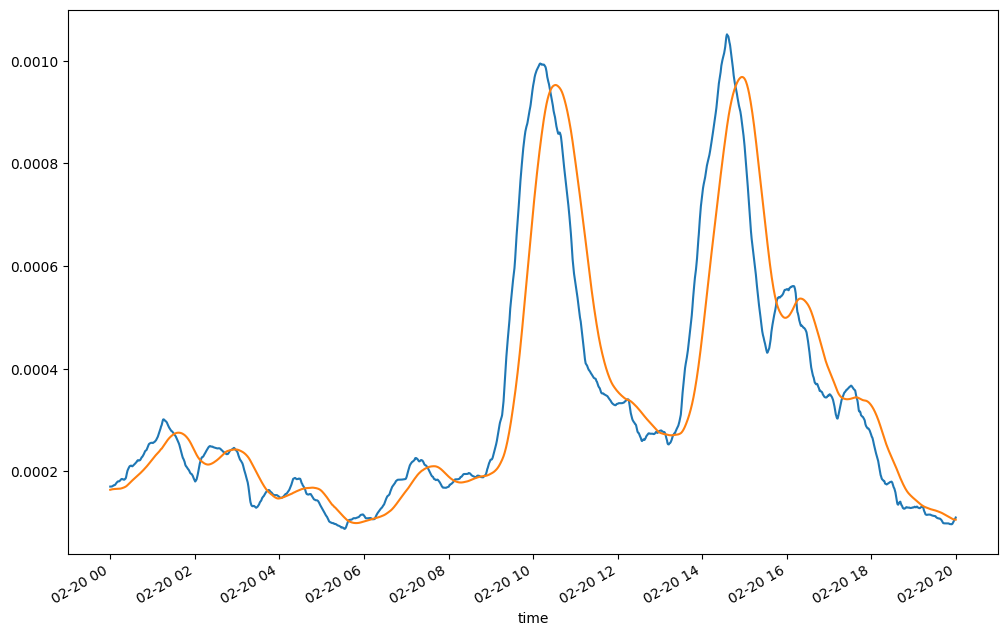

In [41]:
# filtered_df[instrument].plot(figsize = (12, 8))
filtered_df["std"].plot(figsize = (12, 8))
filtered_df["std_sma"].plot(figsize = (12, 8))
# filtered_df["std_upper"].plot(figsize = (12, 8), secondary_y = "position")
# filtered_df["std_lower"].plot(figsize = (12, 8), secondary_y = "position")

plt.show()

In [19]:
M = filtered_df[instrument].values
M = pd.Series(M[-20:])
poly = np.polyfit(M.index, M.values, deg=1)


In [ ]:
poly[0]

In [ ]:
Y = np.polyval(poly, M.index)
Y

In [ ]:
Y[1] - Y[0]